# V3 Model Benchmark: Accuracy & Inference Speed

**Purpose**: Compare all 8 V3 models (4 MLP + 4 PINN Residual) on:
- Full-track accuracy vs RK4 ground truth
- Inference speed from binary model files
- Speed vs accuracy Pareto frontier

**Models**:
| Name | Type | Hidden dims | Params (approx) |
|------|------|-------------|-----------------|
| mlp_v3_shallow_256 | MLP | [256, 256, 128] | ~100k |
| mlp_v3_shallow_512 | MLP | [512, 512, 256] | ~400k |
| mlp_v3_deep_128 | MLP | [128, 128, 128, 128, 64] | ~70k |
| mlp_v3_deep_256 | MLP | [256, 256, 256, 256, 128] | ~300k |
| pinn_v3_res_256_col5 | PINN Residual | [256, 256] | ~68k |
| pinn_v3_res_256_col10 | PINN Residual | [256, 256] | ~68k |
| pinn_v3_res_256_col20 | PINN Residual | [256, 256] | ~68k |
| pinn_v3_res_256_col50 | PINN Residual | [256, 256] | ~68k |

**Input**: `[x, y, tx, ty, q/p, dz]` (6 features)  
**Output**: `[x, y, tx, ty]` (4 features)

In [13]:
import struct
import time
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from collections import OrderedDict

# Setup paths
WORKSPACE = Path("/data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators")
V3_DIR = WORKSPACE / "experiments" / "next_generation" / "V3"
BIN_DIR = WORKSPACE / "experiments" / "ml_models" / "models"

# Add V3 utils to path for RK4 propagator
sys.path.insert(0, str(V3_DIR / "utils"))

# Plotting style
matplotlib.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

print(f"Binary models dir: {BIN_DIR}")
print(f"Available binaries: {sorted([f.name for f in BIN_DIR.glob('*_v3_*.bin')])}")

Binary models dir: /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/ml_models/models
Available binaries: ['mlp_v3_deep_128.bin', 'mlp_v3_deep_256.bin', 'mlp_v3_shallow_256.bin', 'mlp_v3_shallow_512.bin', 'pinn_v3_res_256_col10.bin', 'pinn_v3_res_256_col20.bin', 'pinn_v3_res_256_col5.bin', 'pinn_v3_res_256_col50.bin']


## 1. Binary Model Loader

Load models from C++ binary format:
```
int: model_type (0=MLP, 1=PINN residual)
int: num_layers
For each layer: int rows, int cols, double[rows*cols] weights, double[rows] biases
int: input_size, double[] input_mean, double[] input_std
int: output_size, double[] output_mean, double[] output_std
int: activation_len, char[] activation_name
```

In [14]:
class BinaryModel:
    """Load and run inference from C++ binary model files."""
    
    def __init__(self, bin_path: str):
        self.path = Path(bin_path)
        self.name = self.path.stem
        self._load()
    
    def _load(self):
        """Parse binary file."""
        with open(self.path, 'rb') as f:
            # Model type: 0=MLP, 1=PINN residual
            self.model_type = struct.unpack('i', f.read(4))[0]
            self.is_residual = (self.model_type == 1)
            
            # Number of layers
            num_layers = struct.unpack('i', f.read(4))[0]
            
            # Read layers
            self.weights = []
            self.biases = []
            for _ in range(num_layers):
                rows, cols = struct.unpack('ii', f.read(8))
                W = np.frombuffer(f.read(rows * cols * 8), dtype=np.float64).reshape(rows, cols)
                b = np.frombuffer(f.read(rows * 8), dtype=np.float64).copy()
                self.weights.append(W.copy())
                self.biases.append(b.copy())
            
            # Input normalization
            input_size = struct.unpack('i', f.read(4))[0]
            self.input_mean = np.frombuffer(f.read(input_size * 8), dtype=np.float64).copy()
            self.input_std = np.frombuffer(f.read(input_size * 8), dtype=np.float64).copy()
            
            # Output normalization
            output_size = struct.unpack('i', f.read(4))[0]
            self.output_mean = np.frombuffer(f.read(output_size * 8), dtype=np.float64).copy()
            self.output_std = np.frombuffer(f.read(output_size * 8), dtype=np.float64).copy()
            
            # Activation function name
            act_len = struct.unpack('i', f.read(4))[0]
            self.activation = f.read(act_len).decode('ascii')
        
        # Precompute architecture description
        dims = [self.weights[0].shape[1]]  # input dim
        for W in self.weights:
            dims.append(W.shape[0])
        self.dims = dims
        self.n_params = sum(W.size + b.size for W, b in zip(self.weights, self.biases))
    
    def _activate(self, x):
        """Apply activation function (matching C++ implementation)."""
        if self.activation == 'silu':
            return x / (1.0 + np.exp(-x))  # x * sigmoid(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError(f"Unknown activation: {self.activation}")
    
    def predict_single(self, x_input):
        """
        Run inference on a single sample. Matches C++ forward pass.
        
        Args:
            x_input: [6] = [x, y, tx, ty, qop, dz]
        Returns:
            [4] = [x_f, y_f, tx_f, ty_f]
        """
        # Normalize input
        x = (x_input - self.input_mean) / self.input_std
        
        # Save normalized initial state for PINN residual
        x_norm_init = x[:4].copy() if self.is_residual else None
        
        # Forward pass through all layers
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            x = W @ x + b  # W is (out, in), x is (in,)
            if i < len(self.weights) - 1:  # activation on all but last layer
                x = self._activate(x)
        
        # PINN residual: add in normalized space, then denormalize
        if self.is_residual:
            output = (x + x_norm_init) * self.output_std + self.output_mean
        else:
            output = x * self.output_std + self.output_mean
        
        return output
    
    def predict_batch(self, X):
        """
        Batched inference. X shape: (N, 6) -> (N, 4).
        """
        # Normalize
        x = (X - self.input_mean) / self.input_std
        
        # Save normalized initial state for PINN residual
        x_norm_init = x[:, :4].copy() if self.is_residual else None
        
        # Forward pass
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            x = x @ W.T + b  # Batched: (N, in) @ (in, out) + (out,)
            if i < len(self.weights) - 1:
                x = self._activate(x)
        
        # PINN residual: add in normalized space, then denormalize
        if self.is_residual:
            output = (x + x_norm_init) * self.output_std + self.output_mean
        else:
            output = x * self.output_std + self.output_mean
        
        return output
    
    def __repr__(self):
        type_str = "PINN-Res" if self.is_residual else "MLP"
        return f"BinaryModel({self.name}, {type_str}, {self.dims}, {self.n_params} params, {self.activation})"


# Load all V3 models
MODEL_NAMES = [
    "mlp_v3_shallow_256",
    "mlp_v3_shallow_512",
    "mlp_v3_deep_128",
    "mlp_v3_deep_256",
    "pinn_v3_res_256_col5",
    "pinn_v3_res_256_col10",
    "pinn_v3_res_256_col20",
    "pinn_v3_res_256_col50",
]

models = OrderedDict()
for name in MODEL_NAMES:
    bin_path = BIN_DIR / f"{name}.bin"
    if bin_path.exists():
        models[name] = BinaryModel(bin_path)
        print(models[name])
    else:
        print(f"WARNING: {bin_path} not found!")


print(f"\nLoaded {len(models)} models")
print(f"\nLoaded {len(models)} models")

BinaryModel(mlp_v3_shallow_256, MLP, [6, 256, 256, 128, 4], 100996 params, silu)
BinaryModel(mlp_v3_shallow_512, MLP, [6, 512, 512, 256, 4], 398596 params, silu)
BinaryModel(mlp_v3_deep_128, MLP, [6, 128, 128, 128, 128, 64, 4], 58948 params, silu)
BinaryModel(mlp_v3_deep_256, MLP, [6, 256, 256, 256, 256, 128, 4], 232580 params, silu)
BinaryModel(pinn_v3_res_256_col5, PINN-Res, [6, 256, 256, 4], 68612 params, silu)
BinaryModel(pinn_v3_res_256_col10, PINN-Res, [6, 256, 256, 4], 68612 params, silu)
BinaryModel(pinn_v3_res_256_col20, PINN-Res, [6, 256, 256, 4], 68612 params, silu)
BinaryModel(pinn_v3_res_256_col50, PINN-Res, [6, 256, 256, 4], 68612 params, silu)

Loaded 8 models

Loaded 8 models


## 2. Generate Ground Truth Test Data

Generate random tracks with realistic IC ranges covering full LHCb acceptance, then propagate with RK4 to get ground truth final states.

In [15]:
from rk4_propagator import RK4Integrator, generate_random_track

# Initialize RK4 with real field map (step_size=5mm for high accuracy ground truth)
rk4 = RK4Integrator(step_size=5.0, use_interpolated_field=True)

# Generate test tracks
N_TEST = 100
np.random.seed(42)

# z ranges matching LHCb detector regions
Z_STARTS = [0, 2000, 4000, 6000, 8000]
Z_ENDS   = [2000, 4000, 6000, 8000, 10000]

print(f"Generating {N_TEST} random test tracks with RK4 ground truth...")
print(f"IC ranges: x=±1500mm, y=±1200mm, tx=±0.4, ty=±0.35, p=0.5-100 GeV, dz=500-12000mm (forward only)")

test_inputs = []   # [x, y, tx, ty, qop, dz]
test_outputs = []  # [x_f, y_f, tx_f, ty_f]
test_momenta = []  # momentum in GeV
test_dz = []       # actual |dz|
test_z_starts = [] # z_start for baseline extrapolators that need B field

n_valid = 0
n_attempted = 0
while n_valid < N_TEST:
    # Random starting z region
    region = np.random.randint(0, len(Z_STARTS))
    z_start = np.random.uniform(Z_STARTS[region], Z_ENDS[region])
    
    # Random dz: forward only, matching training range [500, 12000]
    dz = np.random.uniform(500, 12000)
    z_end = z_start + dz
    
    # Skip if z_end outside detector
    if z_end < 0 or z_end > 14500:
        continue
    
    # Generate random track state
    state, momentum = generate_random_track(z_start=z_start)
    
    # Propagate with RK4
    final_state = rk4.propagate(state, z_start, z_end)
    
    n_attempted += 1
    
    # Skip failed propagations
    if not np.all(np.isfinite(final_state)):
        continue
    
    # Build model input: [x, y, tx, ty, qop, dz]
    model_input = np.array([state[0], state[1], state[2], state[3], state[4], dz])
    # Ground truth output: [x_f, y_f, tx_f, ty_f]
    model_output = final_state[:4]
    
    test_inputs.append(model_input)
    test_outputs.append(model_output)
    test_momenta.append(momentum)
    test_dz.append(abs(dz))
    test_z_starts.append(z_start)
    n_valid += 1

test_inputs = np.array(test_inputs)
test_outputs = np.array(test_outputs)
test_momenta = np.array(test_momenta)
test_dz = np.array(test_dz)
test_z_starts = np.array(test_z_starts)

print(f"\nGenerated {n_valid} valid tracks ({n_attempted} attempted, {n_attempted - n_valid} rejected)")
print(f"Momentum range: {test_momenta.min():.2f} - {test_momenta.max():.2f} GeV")
print(f"|dz| range: {test_dz.min():.0f} - {test_dz.max():.0f} mm")
print(f"Input shape: {test_inputs.shape}")
print(f"Output shape: {test_outputs.shape}")

Loading field map from /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/field_maps/twodip.rtf...
  Grid size: 81 × 81 × 146 = 957906 points
  x range: [-4000.0, 4000.0] mm
  y range: [-4000.0, 4000.0] mm
  z range: [-500.0, 14000.0] mm
  Grid spacing: dx=100.0mm, dy=100.0mm, dz=100.0mm
  By at (0, 0, 5000.0): -1.0320 T
  Peak |By|: 33024.0670 T
RK4Integrator initialized with InterpolatedFieldNumpy, step_size=5.0mm
Generating 100 random test tracks with RK4 ground truth...
IC ranges: x=±1500mm, y=±1200mm, tx=±0.4, ty=±0.35, p=0.5-100 GeV, dz=500-12000mm (forward only)

Generated 100 valid tracks (100 attempted, 0 rejected)
Momentum range: 0.56 - 92.50 GeV
|dz| range: 653 - 11937 mm
Input shape: (100, 6)
Output shape: (100, 4)


## 2b. C++ Benchmark: Timing & Predictions

All timing is done in compiled C++ (`-O2`) for a fair comparison. The C++ program implements:
- **Linear** extrapolation (no field)
- **Parabolic** extrapolation (single field eval at midpoint)
- **RK4** integration (step=10mm for timing, step=5mm for ground truth predictions)
- **MLP / PINN** inference from binary weight files

The same program writes predictions so accuracy can be evaluated here.

In [16]:
import subprocess, json

ANALYSIS_DIR = V3_DIR / 'analysis'
FIELD_MAP = WORKSPACE / 'experiments' / 'field_maps' / 'twodip.rtf'

# Write test inputs as binary for C++ program
# Format: int N, then N rows of 7 doubles [x, y, tx, ty, qop, dz, z_start]
test_bin_path = ANALYSIS_DIR / 'test_inputs.bin'
with open(test_bin_path, 'wb') as f:
    import struct
    f.write(struct.pack('i', len(test_inputs)))
    for i in range(len(test_inputs)):
        row = list(test_inputs[i]) + [test_z_starts[i]]  # append z_start
        f.write(struct.pack('7d', *row))
print(f"Wrote {len(test_inputs)} test inputs to {test_bin_path}")

# Build model binary list
model_bins = sorted(BIN_DIR.glob('*_v3_*.bin'))
model_bin_args = [str(p) for p in model_bins]
print(f"Model binaries: {[p.name for p in model_bins]}")

# Run C++ benchmark
cpp_exe = ANALYSIS_DIR / 'benchmark_cpp'
cmd = [str(cpp_exe), str(FIELD_MAP)] + model_bin_args
print(f"\nRunning C++ benchmark...")
result = subprocess.run(cmd, capture_output=True, text=True, cwd=str(ANALYSIS_DIR), timeout=300)

if result.returncode != 0:
    print(f"STDERR:\n{result.stderr}")
    raise RuntimeError(f"C++ benchmark failed with return code {result.returncode}")

print(f"STDERR (info):\n{result.stderr}")

# Parse JSON timing output
cpp_timings = json.loads(result.stdout)
print(f"\nC++ timing results (all in nanoseconds):")
print(f"{'Model':<30s} {'Median (ns)':>12s} {'Mean (ns)':>12s} {'Median (µs)':>12s}")
print("-" * 70)
for name, t in cpp_timings.items():
    print(f"{name:<30s} {t['median_ns']:>12.0f} {t['mean_ns']:>12.0f} {t['median_ns']/1000:>12.2f}")

Wrote 100 test inputs to /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/V3/analysis/test_inputs.bin
Model binaries: ['mlp_v3_deep_128.bin', 'mlp_v3_deep_256.bin', 'mlp_v3_shallow_256.bin', 'mlp_v3_shallow_512.bin', 'pinn_v3_res_256_col10.bin', 'pinn_v3_res_256_col20.bin', 'pinn_v3_res_256_col5.bin', 'pinn_v3_res_256_col50.bin']

Running C++ benchmark...
STDERR (info):
Field map loaded: 81 x 81 x 146 = 957906 points
  x: [-4000, 4000] mm, y: [-4000, 4000] mm, z: [-500, 14000] mm
Model mlp_v3_deep_128: type=0, layers=6, params=58948, act=silu
Model mlp_v3_deep_256: type=0, layers=6, params=232580, act=silu
Model mlp_v3_shallow_256: type=0, layers=4, params=100996, act=silu
Model mlp_v3_shallow_512: type=0, layers=4, params=398596, act=silu
Model pinn_v3_res_256_col10: type=1, layers=3, params=68612, act=silu
Model pinn_v3_res_256_col20: type=1, layers=3, params=68612, act=silu
Model pinn_v3_res_256_col5: type=1, layers=3, params=68612, act=silu
Model p

## 3. Load C++ Predictions & Compute Accuracy

Load predictions from the C++ program for all models (including RK4 ground truth with 5mm step size).

In [17]:
import struct

# Load C++ predictions
pred_path = ANALYSIS_DIR / 'predictions_cpp.bin'
with open(pred_path, 'rb') as f:
    N_pred = struct.unpack('i', f.read(4))[0]
    n_models = struct.unpack('i', f.read(4))[0]
    
    cpp_predictions = {}
    for _ in range(n_models):
        name_len = struct.unpack('i', f.read(4))[0]
        name = f.read(name_len).decode('ascii')
        preds = np.frombuffer(f.read(N_pred * 4 * 8), dtype=np.float64).reshape(N_pred, 4).copy()
        cpp_predictions[name] = preds
        print(f"  {name}: predictions shape = {preds.shape}")

print(f"\nLoaded predictions for {len(cpp_predictions)} models from C++ binary")

# Use RK4 (5mm step) as ground truth
test_outputs_cpp = cpp_predictions.pop('RK4')  # remove from models to benchmark
print(f"\nGround truth (C++ RK4 5mm step): shape = {test_outputs_cpp.shape}")

# Quick sanity check: compare Python vs C++ RK4 ground truth
rk4_diff = np.abs(test_outputs - test_outputs_cpp)
print(f"Python vs C++ RK4 agreement: max diff = {rk4_diff.max():.6e} mm")
print(f"  (should be ~0 if both use same field map and step size)")

  Linear: predictions shape = (100, 4)
  Parabolic: predictions shape = (100, 4)
  RK4: predictions shape = (100, 4)
  mlp_v3_deep_128: predictions shape = (100, 4)
  mlp_v3_deep_256: predictions shape = (100, 4)
  mlp_v3_shallow_256: predictions shape = (100, 4)
  mlp_v3_shallow_512: predictions shape = (100, 4)
  pinn_v3_res_256_col10: predictions shape = (100, 4)
  pinn_v3_res_256_col20: predictions shape = (100, 4)
  pinn_v3_res_256_col5: predictions shape = (100, 4)
  pinn_v3_res_256_col50: predictions shape = (100, 4)

Loaded predictions for 11 models from C++ binary

Ground truth (C++ RK4 5mm step): shape = (100, 4)
Python vs C++ RK4 agreement: max diff = 3.068823e-05 mm
  (should be ~0 if both use same field map and step size)


## 4. Accuracy Evaluation

Compare C++ predictions for all models against the C++ RK4 ground truth (5mm step size).

In [18]:
def compute_metrics(pred, truth):
    """Compute per-component and aggregate error metrics."""
    errors = pred - truth
    x_err, y_err = errors[:, 0], errors[:, 1]
    tx_err, ty_err = errors[:, 2], errors[:, 3]
    pos_err = np.sqrt(x_err**2 + y_err**2)
    slope_err = np.sqrt(tx_err**2 + ty_err**2)
    
    return {
        'x_mae': np.mean(np.abs(x_err)), 'y_mae': np.mean(np.abs(y_err)),
        'tx_mae': np.mean(np.abs(tx_err)), 'ty_mae': np.mean(np.abs(ty_err)),
        'x_rmse': np.sqrt(np.mean(x_err**2)), 'y_rmse': np.sqrt(np.mean(y_err**2)),
        'tx_rmse': np.sqrt(np.mean(tx_err**2)), 'ty_rmse': np.sqrt(np.mean(ty_err**2)),
        'pos_mae': np.mean(pos_err), 'pos_rmse': np.sqrt(np.mean(pos_err**2)),
        'pos_p50': np.median(pos_err), 'pos_p95': np.percentile(pos_err, 95),
        'pos_p99': np.percentile(pos_err, 99),
        'slope_mae': np.mean(slope_err), 'slope_rmse': np.sqrt(np.mean(slope_err**2)),
        'slope_p50': np.median(slope_err), 'slope_p95': np.percentile(slope_err, 95),
        'slope_p99': np.percentile(slope_err, 99),
        'pos_err': pos_err, 'slope_err': slope_err,
        'x_err': x_err, 'y_err': y_err, 'tx_err': tx_err, 'ty_err': ty_err,
    }

# Build timing results dict (convert ns -> µs)
timing_results = {}
for name, t in cpp_timings.items():
    timing_results[name] = {
        'median_us': t['median_ns'] / 1000.0,
        'mean_us': t['mean_ns'] / 1000.0,
        'std_us': t['std_ns'] / 1000.0,
    }

# Compute accuracy metrics for all models
metrics = {}
all_model_names = list(cpp_predictions.keys())  # order from C++
for name in all_model_names:
    metrics[name] = compute_metrics(cpp_predictions[name], test_outputs_cpp)

# Summary table
rk4_med = timing_results['RK4']['median_us']
print(f"{'='*110}")
print(f"{'Model':<28s} {'Time(µs)':>10s} {'Speedup':>8s} {'Pos MAE':>10s} {'Pos RMSE':>10s} {'Pos P95':>10s} "
      f"{'Slp RMSE':>10s} {'Slp P95':>10s}")
print(f"{'':28s} {'(C++)':>10s} {'vs RK4':>8s} {'(mm)':>10s} {'(mm)':>10s} {'(mm)':>10s}")
print("-" * 110)
for name in all_model_names:
    m = metrics[name]
    t = timing_results[name]
    speedup = rk4_med / t['median_us']
    print(f"{name:<28s} {t['median_us']:>10.2f} {speedup:>7.1f}x {m['pos_mae']:>10.3f} {m['pos_rmse']:>10.3f} "
          f"{m['pos_p95']:>10.3f} {m['slope_rmse']:>10.6f} {m['slope_p95']:>10.6f}")

Model                          Time(µs)  Speedup    Pos MAE   Pos RMSE    Pos P95   Slp RMSE    Slp P95
                                  (C++)   vs RK4       (mm)       (mm)       (mm)
--------------------------------------------------------------------------------------------------------------
Linear                             0.04  2130.5x      0.604      1.625      2.382   0.000308   0.000694
Parabolic                          0.09   946.9x      0.476      1.631      1.705   0.000285   0.000401
mlp_v3_deep_128                   64.96     1.3x      0.551      1.013      1.929   0.011483   0.022893
mlp_v3_deep_256                  265.69     0.3x      0.640      1.059      2.681   0.011684   0.020280
mlp_v3_shallow_256               116.16     0.7x      0.569      1.010      2.748   0.009239   0.015890
mlp_v3_shallow_512               465.56     0.2x      0.540      0.960      2.511   0.009438   0.019415
pinn_v3_res_256_col10             79.29     1.1x     50.669     54.396     79.6

## 5. Timing Bar Chart (C++ timings)

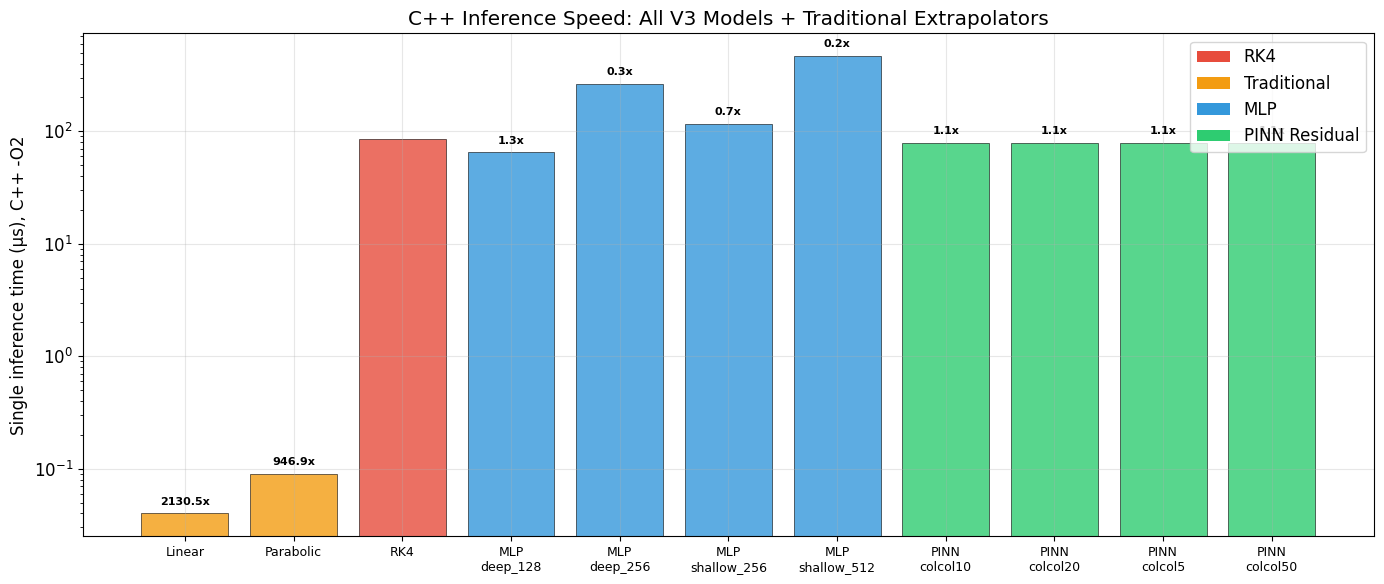

Saved: timing_comparison.png


In [19]:
fig, ax = plt.subplots(figsize=(14, 6))

names = list(timing_results.keys())
medians = [timing_results[n]['median_us'] for n in names]

def get_color(name):
    if name == 'RK4': return '#e74c3c'
    if name in ('Linear', 'Parabolic'): return '#f39c12'
    if name.startswith('mlp'): return '#3498db'
    return '#2ecc71'

colors = [get_color(n) for n in names]
bars = ax.bar(range(len(names)), medians, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

rk4_med = timing_results['RK4']['median_us']
for i, (name, med) in enumerate(zip(names, medians)):
    if name != 'RK4':
        speedup = rk4_med / med
        ax.text(i, med * 1.15, f'{speedup:.1f}x', ha='center', va='bottom', fontsize=8, fontweight='bold')

short_names = [n.replace('mlp_v3_', 'MLP\n').replace('pinn_v3_res_256_', 'PINN\ncol') for n in names]
ax.set_xticks(range(len(names)))
ax.set_xticklabels(short_names, fontsize=9)
ax.set_ylabel('Single inference time (µs), C++ -O2')
ax.set_title('C++ Inference Speed: All V3 Models + Traditional Extrapolators')
ax.set_yscale('log')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='RK4'),
                   Patch(facecolor='#f39c12', label='Traditional'),
                   Patch(facecolor='#3498db', label='MLP'),
                   Patch(facecolor='#2ecc71', label='PINN Residual')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'timing_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: timing_comparison.png")

## 6. Error Distribution Histograms

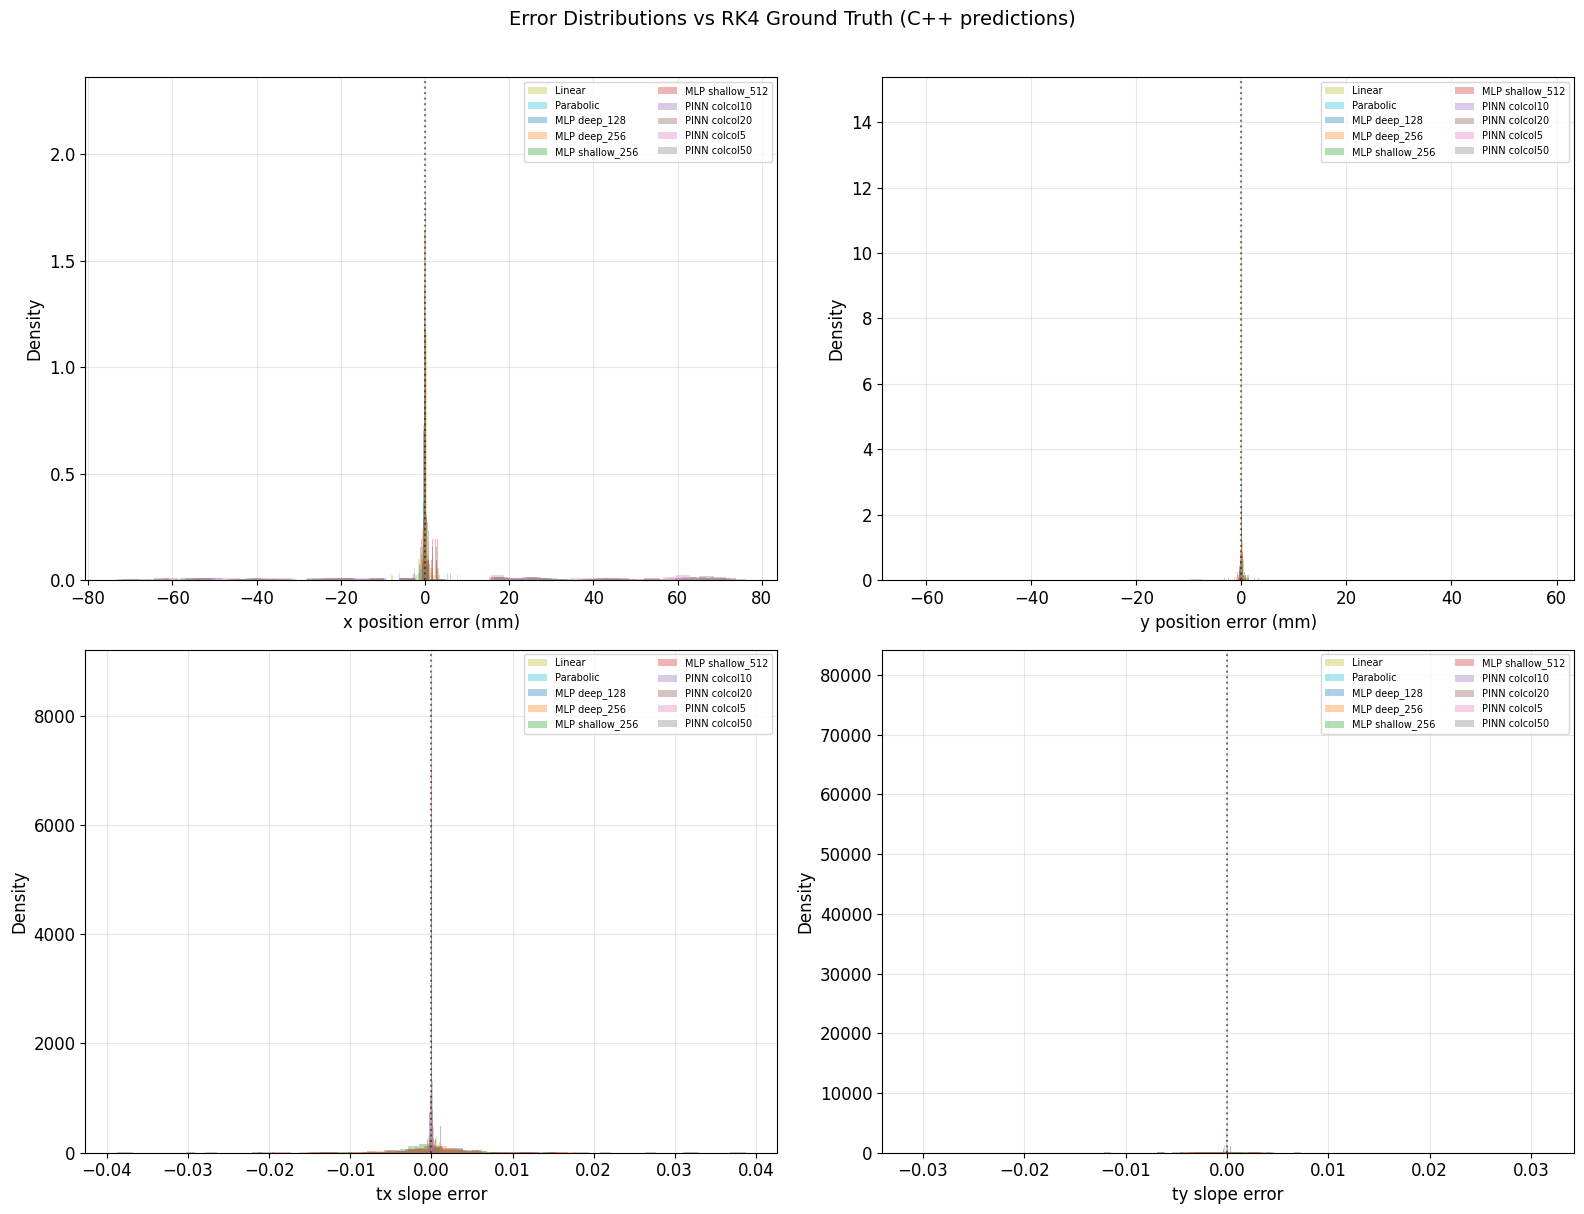

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

components = [
    ('x_err', 'x position error (mm)', axes[0, 0]),
    ('y_err', 'y position error (mm)', axes[0, 1]),
    ('tx_err', 'tx slope error', axes[1, 0]),
    ('ty_err', 'ty slope error', axes[1, 1]),
]

# Color palette
mlp_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
pinn_colors = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
baseline_colors = {'Linear': '#bcbd22', 'Parabolic': '#17becf'}

for err_key, label, ax in components:
    i_mlp, i_pinn = 0, 0
    for name, m in metrics.items():
        errs = m[err_key]
        clip = np.percentile(np.abs(errs), 99)
        errs_clipped = np.clip(errs, -clip, clip)
        
        if name in baseline_colors:
            color = baseline_colors[name]
        elif name.startswith('mlp'):
            color = mlp_colors[i_mlp % 4]; i_mlp += 1
        else:
            color = pinn_colors[i_pinn % 4]; i_pinn += 1
        
        short = name.replace('mlp_v3_', 'MLP ').replace('pinn_v3_res_256_', 'PINN col')
        ax.hist(errs_clipped, bins=40, alpha=0.35, color=color, label=short,
                density=True, histtype='stepfilled', linewidth=1.5)
    
    ax.set_xlabel(label); ax.set_ylabel('Density')
    ax.legend(fontsize=7, ncol=2)
    ax.axvline(0, color='black', linestyle=':', alpha=0.5)

fig.suptitle('Error Distributions vs RK4 Ground Truth (C++ predictions)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'error_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Error vs Momentum and dz

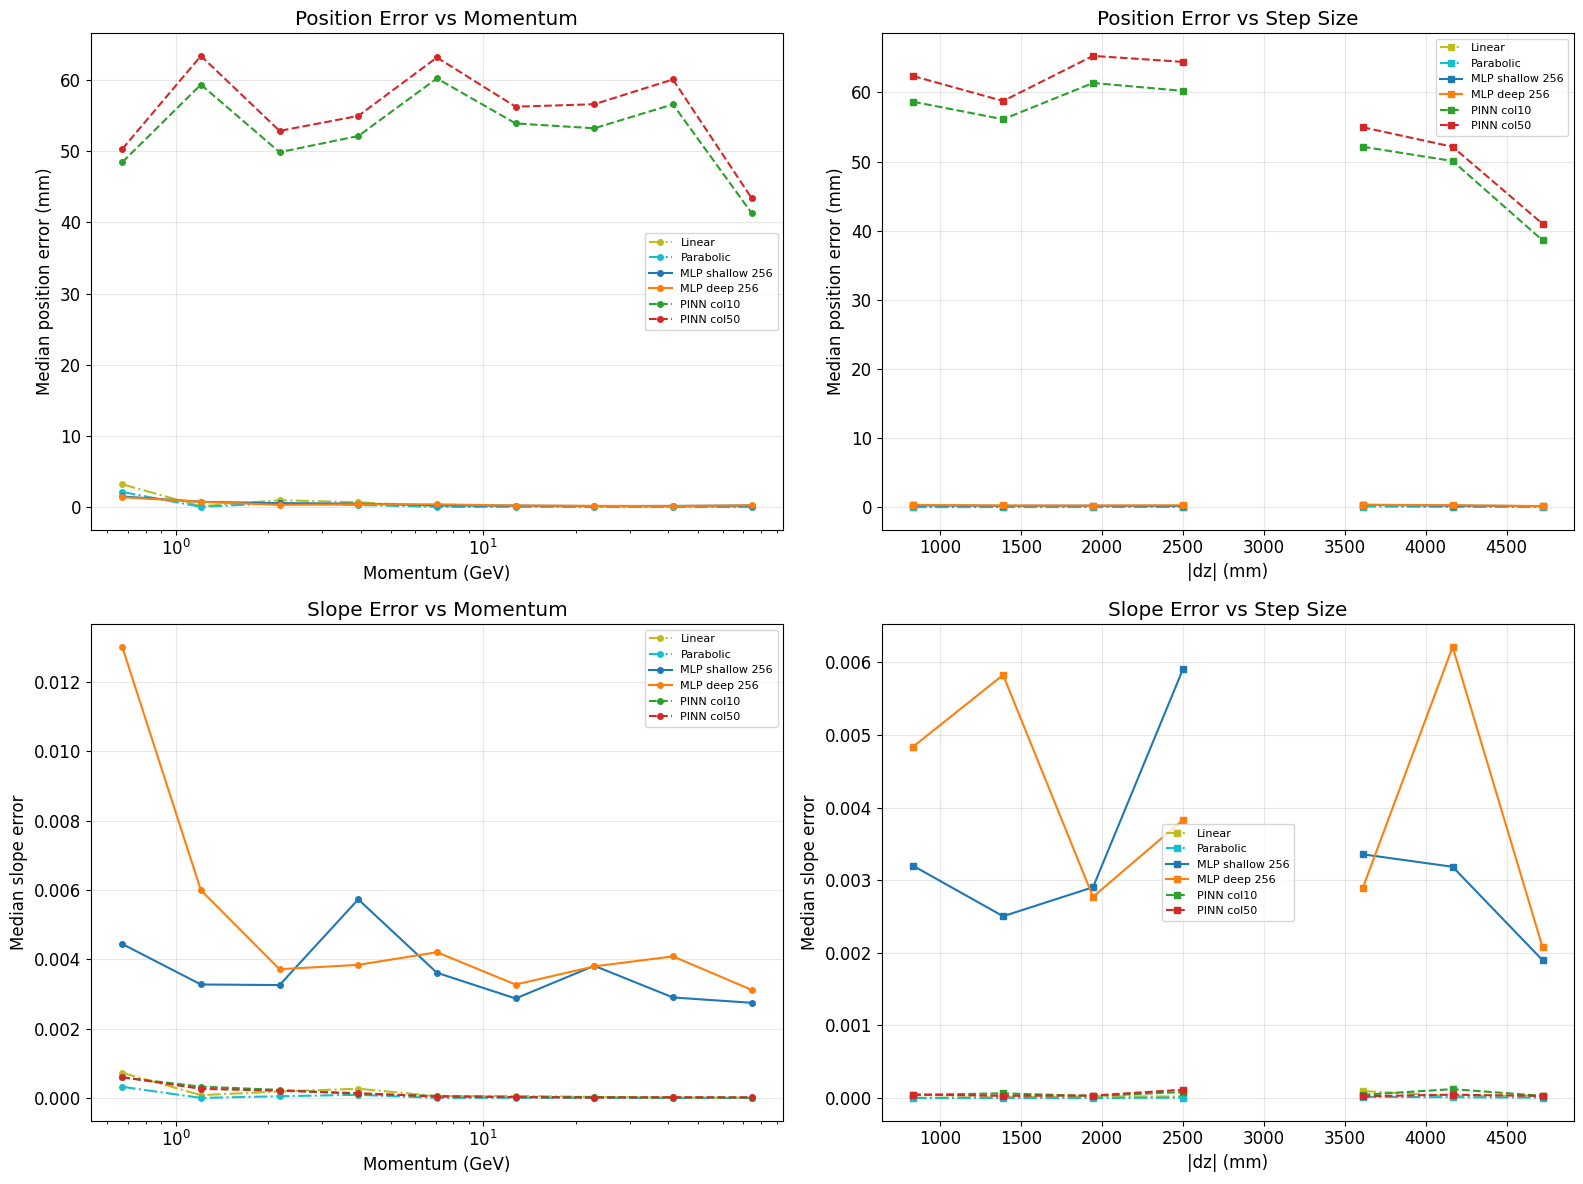

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

representative = {
    'Linear': ('Linear', '#bcbd22', '-.'),
    'Parabolic': ('Parabolic', '#17becf', '-.'),
    'mlp_v3_shallow_256': ('MLP shallow 256', '#1f77b4', '-'),
    'mlp_v3_deep_256': ('MLP deep 256', '#ff7f0e', '-'),
    'pinn_v3_res_256_col10': ('PINN col10', '#2ca02c', '--'),
    'pinn_v3_res_256_col50': ('PINN col50', '#d62728', '--'),
}

p_bins = np.logspace(np.log10(0.5), np.log10(100), 10)
p_centers = np.sqrt(p_bins[:-1] * p_bins[1:])

for name, (label, color, ls) in representative.items():
    if name not in metrics: continue
    m = metrics[name]
    pos_b, slope_b = [], []
    for j in range(len(p_bins) - 1):
        mask = (test_momenta >= p_bins[j]) & (test_momenta < p_bins[j+1])
        pos_b.append(np.median(m['pos_err'][mask]) if mask.sum() > 2 else np.nan)
        slope_b.append(np.median(m['slope_err'][mask]) if mask.sum() > 2 else np.nan)
    axes[0, 0].plot(p_centers, pos_b, ls, color=color, label=label, marker='o', ms=4)
    axes[1, 0].plot(p_centers, slope_b, ls, color=color, label=label, marker='o', ms=4)

for a in [axes[0,0], axes[1,0]]:
    a.set_xscale('log'); a.set_xlabel('Momentum (GeV)'); a.legend(fontsize=8)
axes[0,0].set_ylabel('Median position error (mm)'); axes[0,0].set_title('Position Error vs Momentum')
axes[1,0].set_ylabel('Median slope error'); axes[1,0].set_title('Slope Error vs Momentum')

dz_bins = np.linspace(0, 5000, 10)
dz_centers = 0.5 * (dz_bins[:-1] + dz_bins[1:])

for name, (label, color, ls) in representative.items():
    if name not in metrics: continue
    m = metrics[name]
    pos_b, slope_b = [], []
    for j in range(len(dz_bins) - 1):
        mask = (test_dz >= dz_bins[j]) & (test_dz < dz_bins[j+1])
        pos_b.append(np.median(m['pos_err'][mask]) if mask.sum() > 2 else np.nan)
        slope_b.append(np.median(m['slope_err'][mask]) if mask.sum() > 2 else np.nan)
    axes[0, 1].plot(dz_centers, pos_b, ls, color=color, label=label, marker='s', ms=4)
    axes[1, 1].plot(dz_centers, slope_b, ls, color=color, label=label, marker='s', ms=4)

for a in [axes[0,1], axes[1,1]]:
    a.set_xlabel('|dz| (mm)'); a.legend(fontsize=8)
axes[0,1].set_ylabel('Median position error (mm)'); axes[0,1].set_title('Position Error vs Step Size')
axes[1,1].set_ylabel('Median slope error'); axes[1,1].set_title('Slope Error vs Step Size')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'error_vs_kinematics.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Speed vs Accuracy Pareto Frontier (C++ timings)

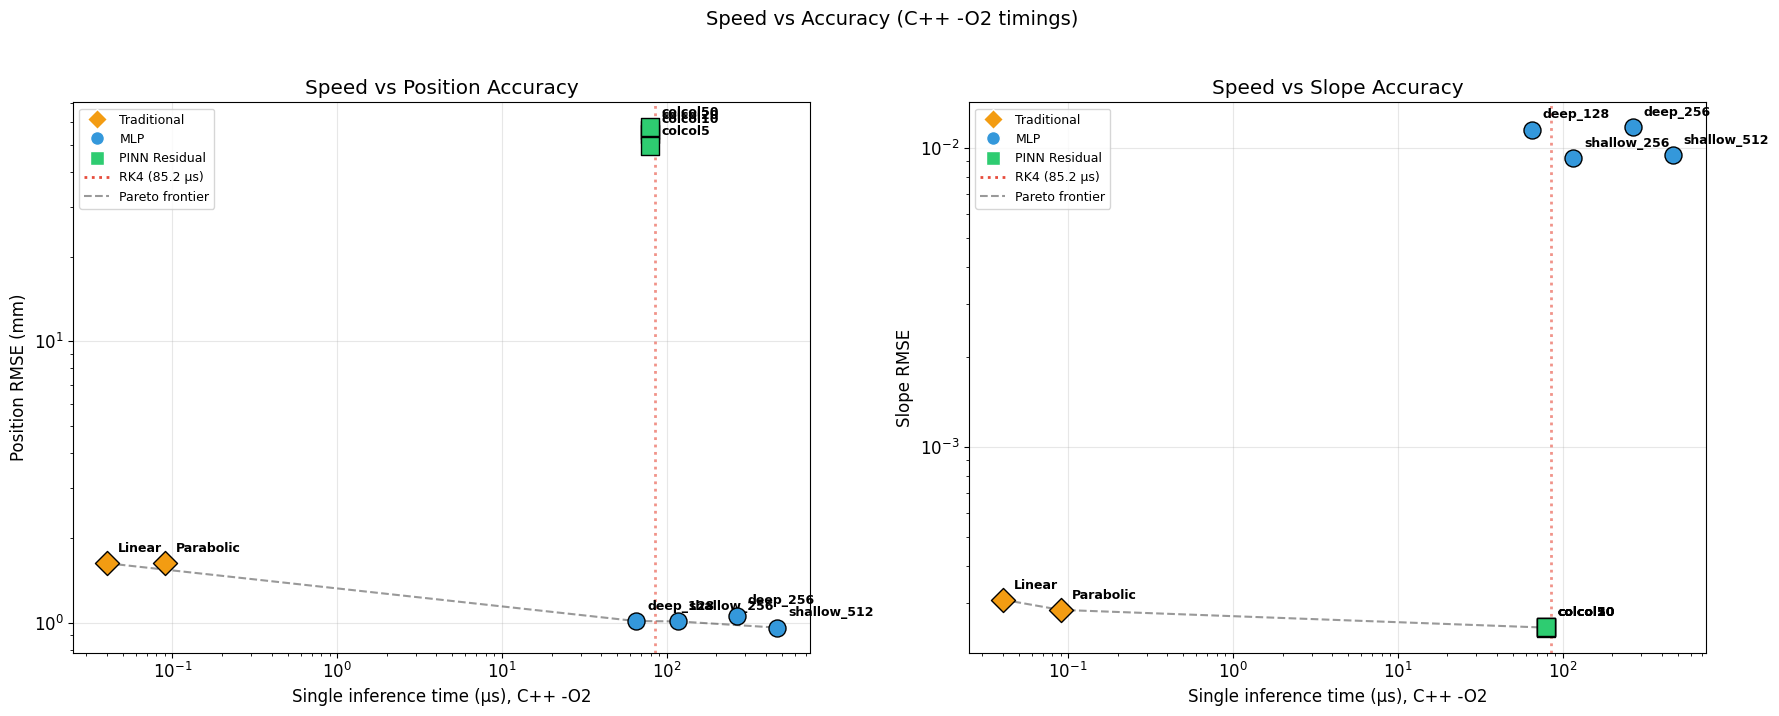

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

model_names_all = list(metrics.keys())
speeds = [timing_results[n]['median_us'] for n in model_names_all]
pos_errors = [metrics[n]['pos_rmse'] for n in model_names_all]
slope_errors = [metrics[n]['slope_rmse'] for n in model_names_all]

for ax, errors, ylabel, title in [
    (axes[0], pos_errors, 'Position RMSE (mm)', 'Speed vs Position Accuracy'),
    (axes[1], slope_errors, 'Slope RMSE', 'Speed vs Slope Accuracy'),
]:
    for i, name in enumerate(model_names_all):
        if name in ('Linear', 'Parabolic'):
            marker, color = 'D', '#f39c12'
        elif name.startswith('mlp'):
            marker, color = 'o', '#3498db'
        else:
            marker, color = 's', '#2ecc71'
        
        ax.scatter(speeds[i], errors[i], s=150, marker=marker, color=color,
                   edgecolors='black', linewidth=1, zorder=5)
        short = name.replace('mlp_v3_', '').replace('pinn_v3_res_256_', 'col')
        ax.annotate(short, (speeds[i], errors[i]),
                    textcoords="offset points", xytext=(8, 8), fontsize=9, fontweight='bold')
    
    # Pareto frontier
    order = np.argsort(speeds)
    pareto_x, pareto_y = [], []; best = float('inf')
    for idx in order:
        if errors[idx] < best:
            pareto_x.append(speeds[idx]); pareto_y.append(errors[idx]); best = errors[idx]
    if len(pareto_x) > 1:
        ax.plot(pareto_x, pareto_y, 'k--', alpha=0.4, linewidth=1.5, label='Pareto frontier')
    
    rk4_speed = timing_results['RK4']['median_us']
    ax.axvline(rk4_speed, color='#e74c3c', ls=':', alpha=0.6, lw=2, label=f'RK4 ({rk4_speed:.1f} µs)')
    
    ax.set_xlabel('Single inference time (µs), C++ -O2')
    ax.set_ylabel(ylabel); ax.set_title(title)
    ax.set_xscale('log'); ax.set_yscale('log')
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='D', color='w', markerfacecolor='#f39c12', ms=10, label='Traditional'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', ms=10, label='MLP'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='#2ecc71', ms=10, label='PINN Residual'),
        Line2D([0], [0], color='#e74c3c', ls=':', lw=2, label=f'RK4 ({rk4_speed:.1f} µs)'),
        Line2D([0], [0], color='black', ls='--', alpha=0.4, lw=1.5, label='Pareto frontier'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.suptitle('Speed vs Accuracy (C++ -O2 timings)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'speed_vs_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Per-Component Accuracy

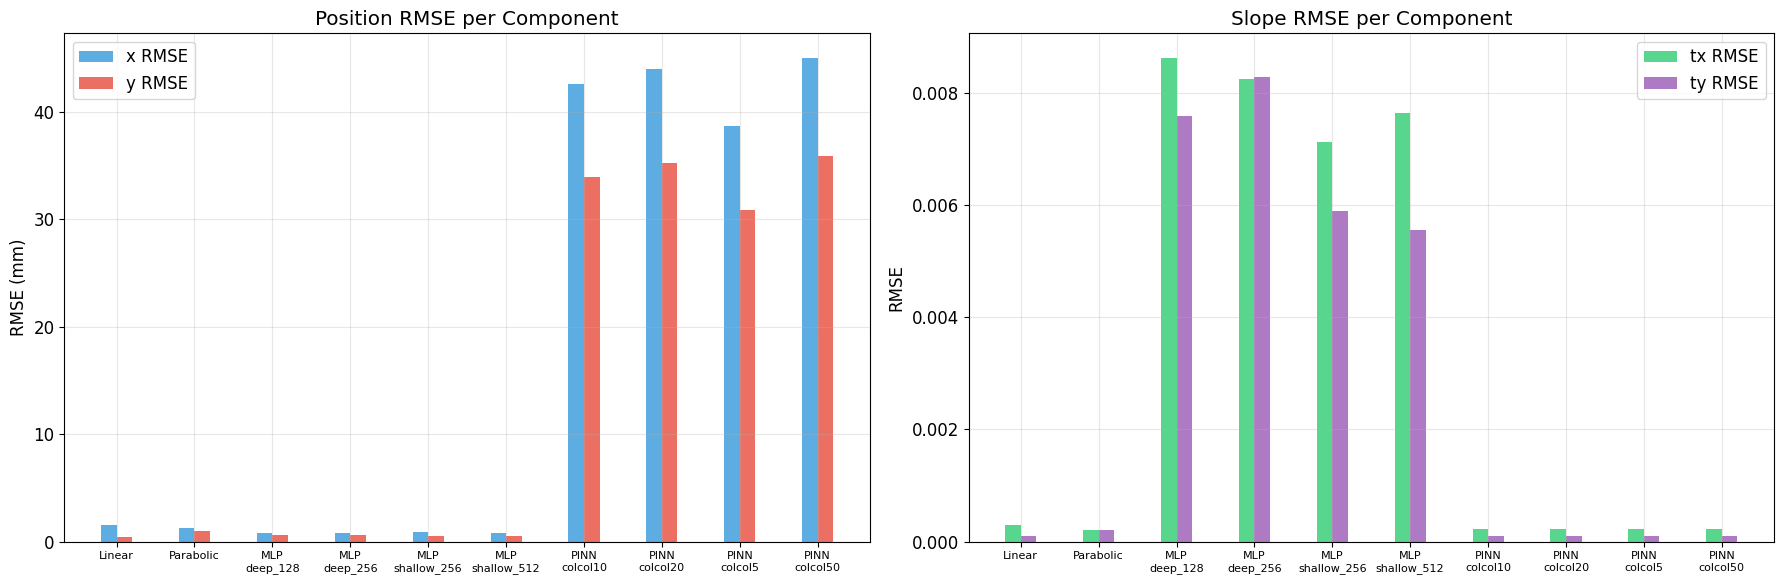

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

model_labels = [n.replace('mlp_v3_', 'MLP\n').replace('pinn_v3_res_256_', 'PINN\ncol') 
                for n in all_model_names]
x_pos = np.arange(len(all_model_names))
width = 0.2

ax = axes[0]
ax.bar(x_pos - width/2, [metrics[n]['x_rmse'] for n in all_model_names], width, label='x RMSE', color='#3498db', alpha=0.8)
ax.bar(x_pos + width/2, [metrics[n]['y_rmse'] for n in all_model_names], width, label='y RMSE', color='#e74c3c', alpha=0.8)
ax.set_xticks(x_pos); ax.set_xticklabels(model_labels, fontsize=8)
ax.set_ylabel('RMSE (mm)'); ax.set_title('Position RMSE per Component'); ax.legend()

ax = axes[1]
ax.bar(x_pos - width/2, [metrics[n]['tx_rmse'] for n in all_model_names], width, label='tx RMSE', color='#2ecc71', alpha=0.8)
ax.bar(x_pos + width/2, [metrics[n]['ty_rmse'] for n in all_model_names], width, label='ty RMSE', color='#9b59b6', alpha=0.8)
ax.set_xticks(x_pos); ax.set_xticklabels(model_labels, fontsize=8)
ax.set_ylabel('RMSE'); ax.set_title('Slope RMSE per Component'); ax.legend()

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'component_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Summary Table & CSV Export

In [24]:
import pandas as pd

def get_type(name):
    if name in ('Linear', 'Parabolic'): return name
    if 'pinn' in name: return 'PINN'
    return 'MLP'

def get_nparams(name):
    if name in ('Linear', 'Parabolic'): return 0
    if name in models: return models[name].n_params
    return 0

rows = []
rk4_med = timing_results['RK4']['median_us']
for name in all_model_names:
    m = metrics[name]
    t = timing_results[name]
    rows.append({
        'model': name, 'type': get_type(name), 'n_params': get_nparams(name),
        'median_time_us': t['median_us'], 'mean_time_us': t['mean_us'],
        'speedup_vs_rk4': rk4_med / t['median_us'],
        'pos_mae_mm': m['pos_mae'], 'pos_rmse_mm': m['pos_rmse'],
        'pos_p50_mm': m['pos_p50'], 'pos_p95_mm': m['pos_p95'],
        'slope_mae': m['slope_mae'], 'slope_rmse': m['slope_rmse'],
        'slope_p50': m['slope_p50'], 'slope_p95': m['slope_p95'],
        'x_rmse_mm': m['x_rmse'], 'y_rmse_mm': m['y_rmse'],
        'tx_rmse': m['tx_rmse'], 'ty_rmse': m['ty_rmse'],
    })

df = pd.DataFrame(rows)

# Add RK4 timing row
rk4_row = pd.DataFrame([{'model': 'RK4 (ground truth)', 'type': 'RK4', 'n_params': 0,
    'median_time_us': rk4_med, 'mean_time_us': timing_results['RK4']['mean_us'],
    'speedup_vs_rk4': 1.0}])
df = pd.concat([rk4_row, df], ignore_index=True)

csv_path = ANALYSIS_DIR / 'benchmark_results_v3.csv'
df.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")

print(f"\n{'='*130}")
print(f"BENCHMARK SUMMARY - V3 Models + Baselines (C++ -O2 timings)")
print(f"{'='*130}")
display_cols = ['model', 'type', 'n_params', 'median_time_us', 'speedup_vs_rk4',
                'pos_rmse_mm', 'pos_p95_mm', 'slope_rmse', 'slope_p95']
print(df[display_cols].to_string(index=False, float_format='%.4f'))
print(f"\nTest: {N_TEST} tracks, p=0.5-100 GeV, |dz|=50-5000mm")
print(f"Ground truth: C++ RK4 with 5mm step, real field map (twodip.rtf)")
print(f"Timings: C++ compiled with g++ -O2, single-sample inference")

Saved: /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/V3/analysis/benchmark_results_v3.csv

BENCHMARK SUMMARY - V3 Models + Baselines (C++ -O2 timings)
                model      type  n_params  median_time_us  speedup_vs_rk4  pos_rmse_mm  pos_p95_mm  slope_rmse  slope_p95
   RK4 (ground truth)       RK4         0         85.2200          1.0000          NaN         NaN         NaN        NaN
               Linear    Linear         0          0.0400       2130.5000       1.6250      2.3822      0.0003     0.0007
            Parabolic Parabolic         0          0.0900        946.8889       1.6310      1.7053      0.0003     0.0004
      mlp_v3_deep_128       MLP     58948         64.9620          1.3118       1.0125      1.9292      0.0115     0.0229
      mlp_v3_deep_256       MLP    232580        265.6910          0.3207       1.0588      2.6807      0.0117     0.0203
   mlp_v3_shallow_256       MLP    100996        116.1590          0.7336       